In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
# from vqVAE import VQVAE
from vqVAE_custom import VQVAE


import warnings
warnings.filterwarnings("ignore")

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reconstruct2(batch, model):
    z_e = model.encode(batch.float().to(device))[0]
    z_q, _ , _= model.vq_layer(z_e)
    img_hat = model.decode(z_q)
    return img_hat

def reconstruct(batch, model):
    output, _, _, _ = model(batch.float())
    return output

def save_model(model, epoch, ):
    checkpoint_path = os.path.join( os.getcwd() , model_name )
    torch.save({'epoch' : epoch,
                'model_state_dict': model.state_dict()}, checkpoint_path)

def visualize_batch(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [3]:
###########################        Training ....      #################################
def dice_loss(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width]
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Ensure that the prediction is in probability space (use softmax if logits are provided)
    # Uncomment the following line if your model does not already output probabilities
    preds = F.softmax(preds, dim=1)  # Apply softmax over channel dimension (4 channels)

    # Flatten predictions and targets to calculate Dice coefficient for each channel
    preds_flat = preds.contiguous().view(preds.shape[0], preds.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss

import torch
import torch.nn.functional as F

def dice_loss_hard(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels using binary masks.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width] (logits or soft predictions)
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Apply softmax over channel dimension (4 channels) to convert logits to probabilities
    preds = F.softmax(preds, dim=1)

    # Convert probabilities to binary one-hot predictions by using argmax and one-hot encoding
    preds_bin = torch.argmax(preds, dim=1)  # Shape: [batch_size, height, width] (class index for each pixel)
    preds_onehot = F.one_hot(preds_bin, num_classes=4).permute(0, 3, 1, 2).float()  # Shape: [batch_size, 4, height, width]

    # Flatten predictions and targets for dice coefficient calculation
    preds_flat = preds_onehot.contiguous().view(preds_onehot.shape[0], preds_onehot.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    # Calculate intersection and union
    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    # Calculate Dice coefficient and Dice loss
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss



def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            
            # Loss and backward
            loss = dice_loss_hard(inputs, outputs)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss




## Preparing Dataset 

In [4]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [5]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [6]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

NiftiImageIO (0x8640d10): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8640d10): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8602820): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8602820): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8828a40): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8828a40): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8602820): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame11_gt.nii.gz has unexpected scales in

## Prepairing the model

In [7]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 

In [12]:
ACDC_VQVAE = VQVAE(in_channels, D, K)

input = torch.rand(16, 4, 128, 128)

NameError: name 'img_size' is not defined

In [8]:
y = ACDC_VQVAE(input)
z_e = ACDC_VQVAE.encode(input)[0]
z_q, _ , _= ACDC_VQVAE.vq_layer(z_e)
codeBook = ACDC_VQVAE.vq_layer.embedding

## Training the Model

In [9]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [9]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models/vqvae_104_bestmodel.pth'


NameError: name 'ACDC_VQVAE' is not defined

In [11]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [ ]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model, epoch)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

100%|██████████| 119/119 [00:05<00:00, 23.62batch/s, loss=0.786]


Epoch 0: Train Loss: 18.1054


100%|██████████| 119/119 [00:05<00:00, 22.69batch/s, loss=0.547]


Epoch 1: Train Loss: 0.4496


100%|██████████| 119/119 [00:04<00:00, 24.25batch/s, loss=0.354]


Epoch 2: Train Loss: 4.1086


100%|██████████| 119/119 [00:05<00:00, 22.66batch/s, loss=0.186]


Epoch 3: Train Loss: 0.5862


100%|██████████| 119/119 [00:04<00:00, 24.24batch/s, loss=0.119]


Epoch 4: Train Loss: 0.1514


100%|██████████| 119/119 [00:05<00:00, 23.10batch/s, loss=0.141]


Epoch 5: Train Loss: 0.1292


100%|██████████| 119/119 [00:05<00:00, 22.78batch/s, loss=0.105] 


Epoch 6: Train Loss: 0.0986


100%|██████████| 119/119 [00:05<00:00, 23.25batch/s, loss=0.102] 


Epoch 7: Train Loss: 0.0908


100%|██████████| 119/119 [00:05<00:00, 22.71batch/s, loss=0.0836]


Epoch 8: Train Loss: 0.0851


100%|██████████| 119/119 [00:05<00:00, 23.54batch/s, loss=0.089] 


Epoch 9: Train Loss: 0.0829


100%|██████████| 119/119 [00:05<00:00, 23.45batch/s, loss=0.0954]


Epoch 10: Train Loss: 0.0813


100%|██████████| 119/119 [00:05<00:00, 21.30batch/s, loss=0.0816]


Epoch 11: Train Loss: 0.0792


100%|██████████| 119/119 [00:04<00:00, 24.65batch/s, loss=0.0746]


Epoch 12: Train Loss: 0.0778


100%|██████████| 119/119 [00:05<00:00, 22.90batch/s, loss=0.0899]


Epoch 13: Train Loss: 0.0767


100%|██████████| 119/119 [00:04<00:00, 26.45batch/s, loss=0.0734]


Epoch 14: Train Loss: 0.0758


100%|██████████| 119/119 [00:05<00:00, 23.35batch/s, loss=0.0577]


Epoch 15: Train Loss: 0.0751


100%|██████████| 119/119 [00:05<00:00, 23.22batch/s, loss=0.0719]


Epoch 16: Train Loss: 0.0746


100%|██████████| 119/119 [00:05<00:00, 23.15batch/s, loss=0.0702]


Epoch 17: Train Loss: 0.0737


100%|██████████| 119/119 [00:05<00:00, 22.10batch/s, loss=0.0825]


Epoch 18: Train Loss: 0.0732


100%|██████████| 119/119 [00:04<00:00, 24.26batch/s, loss=0.0631]


Epoch 19: Train Loss: 0.0726


100%|██████████| 119/119 [00:04<00:00, 26.57batch/s, loss=0.0796]


Epoch 20: Train Loss: 0.0723


100%|██████████| 119/119 [00:04<00:00, 24.92batch/s, loss=0.0639]


Epoch 21: Train Loss: 0.0719


100%|██████████| 119/119 [00:05<00:00, 23.37batch/s, loss=0.0643]


Epoch 22: Train Loss: 0.0715


100%|██████████| 119/119 [00:05<00:00, 22.20batch/s, loss=0.0714]


Epoch 23: Train Loss: 0.0711


100%|██████████| 119/119 [00:05<00:00, 22.19batch/s, loss=0.0661]


Epoch 24: Train Loss: 0.0707


100%|██████████| 119/119 [00:05<00:00, 21.78batch/s, loss=0.0685]


Epoch 25: Train Loss: 0.0703


100%|██████████| 119/119 [00:05<00:00, 22.37batch/s, loss=0.0602]


Epoch 26: Train Loss: 0.0697


100%|██████████| 119/119 [00:04<00:00, 24.09batch/s, loss=0.0569]


Epoch 27: Train Loss: 0.0693


100%|██████████| 119/119 [00:04<00:00, 23.96batch/s, loss=0.0619]


Epoch 28: Train Loss: 0.0690


100%|██████████| 119/119 [00:04<00:00, 24.21batch/s, loss=0.0745]


Epoch 29: Train Loss: 0.0688


100%|██████████| 119/119 [00:04<00:00, 24.52batch/s, loss=0.0761]


Epoch 30: Train Loss: 0.0683


100%|██████████| 119/119 [00:04<00:00, 24.96batch/s, loss=0.0595]


Epoch 31: Train Loss: 0.0680


100%|██████████| 119/119 [00:04<00:00, 25.74batch/s, loss=0.059] 


Epoch 32: Train Loss: 0.0678


100%|██████████| 119/119 [00:04<00:00, 25.64batch/s, loss=0.0659]


Epoch 33: Train Loss: 0.0675


100%|██████████| 119/119 [00:04<00:00, 24.23batch/s, loss=0.0571]


Epoch 34: Train Loss: 0.0673


100%|██████████| 119/119 [00:04<00:00, 24.78batch/s, loss=0.0767]


Epoch 35: Train Loss: 0.0669


100%|██████████| 119/119 [00:04<00:00, 25.80batch/s, loss=0.0765]


Epoch 36: Train Loss: 0.0664


100%|██████████| 119/119 [00:04<00:00, 25.57batch/s, loss=0.0694]


Epoch 37: Train Loss: 0.0659


100%|██████████| 119/119 [00:04<00:00, 24.04batch/s, loss=0.0798]


Epoch 38: Train Loss: 0.0657


100%|██████████| 119/119 [00:04<00:00, 24.88batch/s, loss=0.0603]


Epoch 39: Train Loss: 0.0653


100%|██████████| 119/119 [00:04<00:00, 25.99batch/s, loss=0.0587]


Epoch 40: Train Loss: 0.0650


100%|██████████| 119/119 [00:04<00:00, 25.99batch/s, loss=0.0649]


Epoch 41: Train Loss: 0.0645


100%|██████████| 119/119 [00:04<00:00, 24.98batch/s, loss=0.0455]


Epoch 42: Train Loss: 0.0643


100%|██████████| 119/119 [00:04<00:00, 24.75batch/s, loss=0.0635]


Epoch 43: Train Loss: 0.0639


100%|██████████| 119/119 [00:04<00:00, 24.17batch/s, loss=0.0469]


Epoch 44: Train Loss: 0.0636


100%|██████████| 119/119 [00:04<00:00, 24.56batch/s, loss=0.0702]


Epoch 45: Train Loss: 0.0633


100%|██████████| 119/119 [00:05<00:00, 23.53batch/s, loss=0.059] 


Epoch 46: Train Loss: 0.0630


100%|██████████| 119/119 [00:04<00:00, 24.25batch/s, loss=0.0477]


Epoch 47: Train Loss: 0.0626


100%|██████████| 119/119 [00:04<00:00, 23.91batch/s, loss=0.0533]


Epoch 48: Train Loss: 0.0624


100%|██████████| 119/119 [00:05<00:00, 23.59batch/s, loss=0.0455]


Epoch 49: Train Loss: 0.0622


100%|██████████| 119/119 [00:04<00:00, 23.87batch/s, loss=0.0678]


Epoch 50: Train Loss: 0.0620


100%|██████████| 119/119 [00:04<00:00, 25.47batch/s, loss=0.0733]


Epoch 51: Train Loss: 0.0617


100%|██████████| 119/119 [00:04<00:00, 23.84batch/s, loss=0.0669]


Epoch 52: Train Loss: 0.0617


100%|██████████| 119/119 [00:04<00:00, 24.16batch/s, loss=0.0693]


Epoch 53: Train Loss: 0.0615


100%|██████████| 119/119 [00:05<00:00, 23.28batch/s, loss=0.0611]


Epoch 54: Train Loss: 0.0613


100%|██████████| 119/119 [00:05<00:00, 22.62batch/s, loss=0.0675]


Epoch 55: Train Loss: 0.0611


100%|██████████| 119/119 [00:05<00:00, 23.31batch/s, loss=0.0588]


Epoch 56: Train Loss: 0.0611


100%|██████████| 119/119 [00:04<00:00, 24.16batch/s, loss=0.0602]


Epoch 57: Train Loss: 0.0608


100%|██████████| 119/119 [00:05<00:00, 22.91batch/s, loss=0.0538]


Epoch 58: Train Loss: 0.0608


100%|██████████| 119/119 [00:04<00:00, 24.54batch/s, loss=0.0644]


Epoch 59: Train Loss: 0.0605


100%|██████████| 119/119 [00:05<00:00, 23.38batch/s, loss=0.0746]


Epoch 60: Train Loss: 0.0604


100%|██████████| 119/119 [00:05<00:00, 23.30batch/s, loss=0.0823]


Epoch 61: Train Loss: 0.0603


100%|██████████| 119/119 [00:05<00:00, 23.49batch/s, loss=0.0371]


Epoch 62: Train Loss: 0.0601


100%|██████████| 119/119 [00:05<00:00, 22.48batch/s, loss=0.063] 


Epoch 63: Train Loss: 0.0600


100%|██████████| 119/119 [00:05<00:00, 23.08batch/s, loss=0.0696]


Epoch 64: Train Loss: 0.0599


100%|██████████| 119/119 [00:04<00:00, 24.06batch/s, loss=0.0604]


Epoch 65: Train Loss: 0.0599


100%|██████████| 119/119 [00:05<00:00, 23.23batch/s, loss=0.0488]


Epoch 66: Train Loss: 0.0597


100%|██████████| 119/119 [00:04<00:00, 23.84batch/s, loss=0.0544]


Epoch 67: Train Loss: 0.0596


100%|██████████| 119/119 [00:05<00:00, 22.75batch/s, loss=0.0508]


Epoch 68: Train Loss: 0.0596


100%|██████████| 119/119 [00:05<00:00, 21.86batch/s, loss=0.0672]


Epoch 69: Train Loss: 0.0595


100%|██████████| 119/119 [00:05<00:00, 22.75batch/s, loss=0.0735]


Epoch 70: Train Loss: 0.0595


100%|██████████| 119/119 [00:05<00:00, 23.28batch/s, loss=0.0667]


Epoch 71: Train Loss: 0.0593


100%|██████████| 119/119 [00:05<00:00, 22.70batch/s, loss=0.0789]


Epoch 72: Train Loss: 0.0592


100%|██████████| 119/119 [00:05<00:00, 23.78batch/s, loss=0.0589]


Epoch 73: Train Loss: 0.0591


100%|██████████| 119/119 [00:04<00:00, 24.51batch/s, loss=0.0637]


Epoch 74: Train Loss: 0.0589


100%|██████████| 119/119 [00:04<00:00, 24.65batch/s, loss=0.0598]


Epoch 75: Train Loss: 0.0588


100%|██████████| 119/119 [00:05<00:00, 23.54batch/s, loss=0.0571]


Epoch 76: Train Loss: 0.0589


100%|██████████| 119/119 [00:04<00:00, 23.86batch/s, loss=0.0417]


Epoch 77: Train Loss: 0.0587


100%|██████████| 119/119 [00:04<00:00, 24.05batch/s, loss=0.0683]


Epoch 78: Train Loss: 0.0585


100%|██████████| 119/119 [00:04<00:00, 24.29batch/s, loss=0.0466]


Epoch 79: Train Loss: 0.0584


100%|██████████| 119/119 [00:04<00:00, 24.46batch/s, loss=0.0549]


Epoch 80: Train Loss: 0.0583


100%|██████████| 119/119 [00:04<00:00, 24.39batch/s, loss=0.0578]


Epoch 81: Train Loss: 0.0583


100%|██████████| 119/119 [00:04<00:00, 24.60batch/s, loss=0.0663]


Epoch 82: Train Loss: 0.0581


100%|██████████| 119/119 [00:04<00:00, 24.64batch/s, loss=0.0657]


Epoch 83: Train Loss: 0.0582


100%|██████████| 119/119 [00:05<00:00, 23.52batch/s, loss=0.0365]


Epoch 84: Train Loss: 0.0580


100%|██████████| 119/119 [00:04<00:00, 25.05batch/s, loss=0.0448]


Epoch 85: Train Loss: 0.0580


100%|██████████| 119/119 [00:04<00:00, 24.24batch/s, loss=0.0617]


Epoch 86: Train Loss: 0.0579


100%|██████████| 119/119 [00:05<00:00, 23.24batch/s, loss=0.0574]


Epoch 87: Train Loss: 0.0578


100%|██████████| 119/119 [00:04<00:00, 24.37batch/s, loss=0.0506]


Epoch 88: Train Loss: 0.0578


100%|██████████| 119/119 [00:05<00:00, 22.97batch/s, loss=0.0686]


Epoch 89: Train Loss: 0.0577


100%|██████████| 119/119 [00:05<00:00, 22.86batch/s, loss=0.0395]


Epoch 90: Train Loss: 0.0577


100%|██████████| 119/119 [00:04<00:00, 24.72batch/s, loss=0.0555]


Epoch 91: Train Loss: 0.0576


100%|██████████| 119/119 [00:04<00:00, 24.10batch/s, loss=0.0647]


Epoch 92: Train Loss: 0.0575


100%|██████████| 119/119 [00:05<00:00, 23.37batch/s, loss=0.0665]


Epoch 93: Train Loss: 0.0575


100%|██████████| 119/119 [00:05<00:00, 21.73batch/s, loss=0.0453]


Epoch 94: Train Loss: 0.0573


100%|██████████| 119/119 [00:04<00:00, 24.02batch/s, loss=0.0402]


Epoch 95: Train Loss: 0.0571


100%|██████████| 119/119 [00:05<00:00, 21.69batch/s, loss=0.0614]


Epoch 96: Train Loss: 0.0571


100%|██████████| 119/119 [00:05<00:00, 22.86batch/s, loss=0.0547]


Epoch 97: Train Loss: 0.0571


100%|██████████| 119/119 [00:05<00:00, 22.55batch/s, loss=0.0571]


Epoch 98: Train Loss: 0.0570


100%|██████████| 119/119 [00:05<00:00, 22.47batch/s, loss=0.0854]


Epoch 99: Train Loss: 0.0571
Training complete.


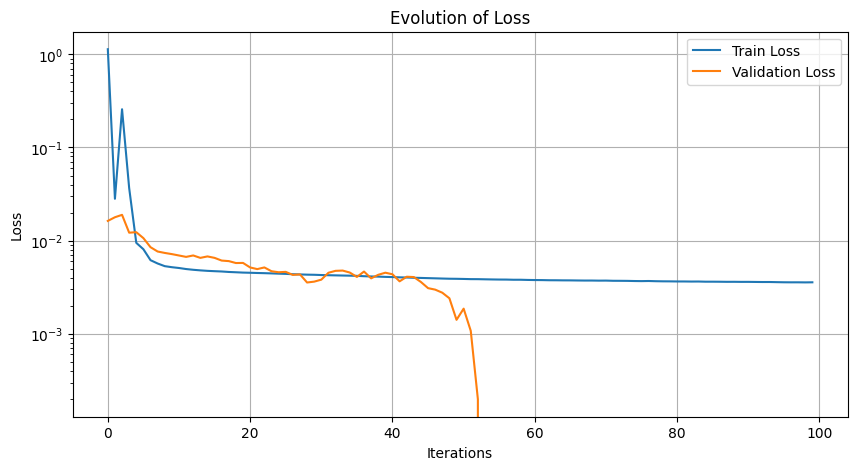

In [14]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of Loss')
plt.legend()
plt.grid()
plt.show()

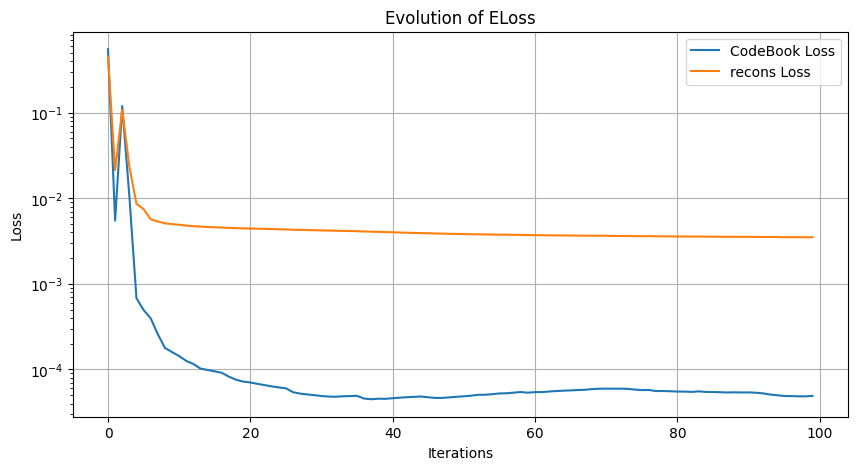

In [17]:
recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
# plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of ELoss')
plt.legend()
plt.grid()
plt.show()

# Test ...

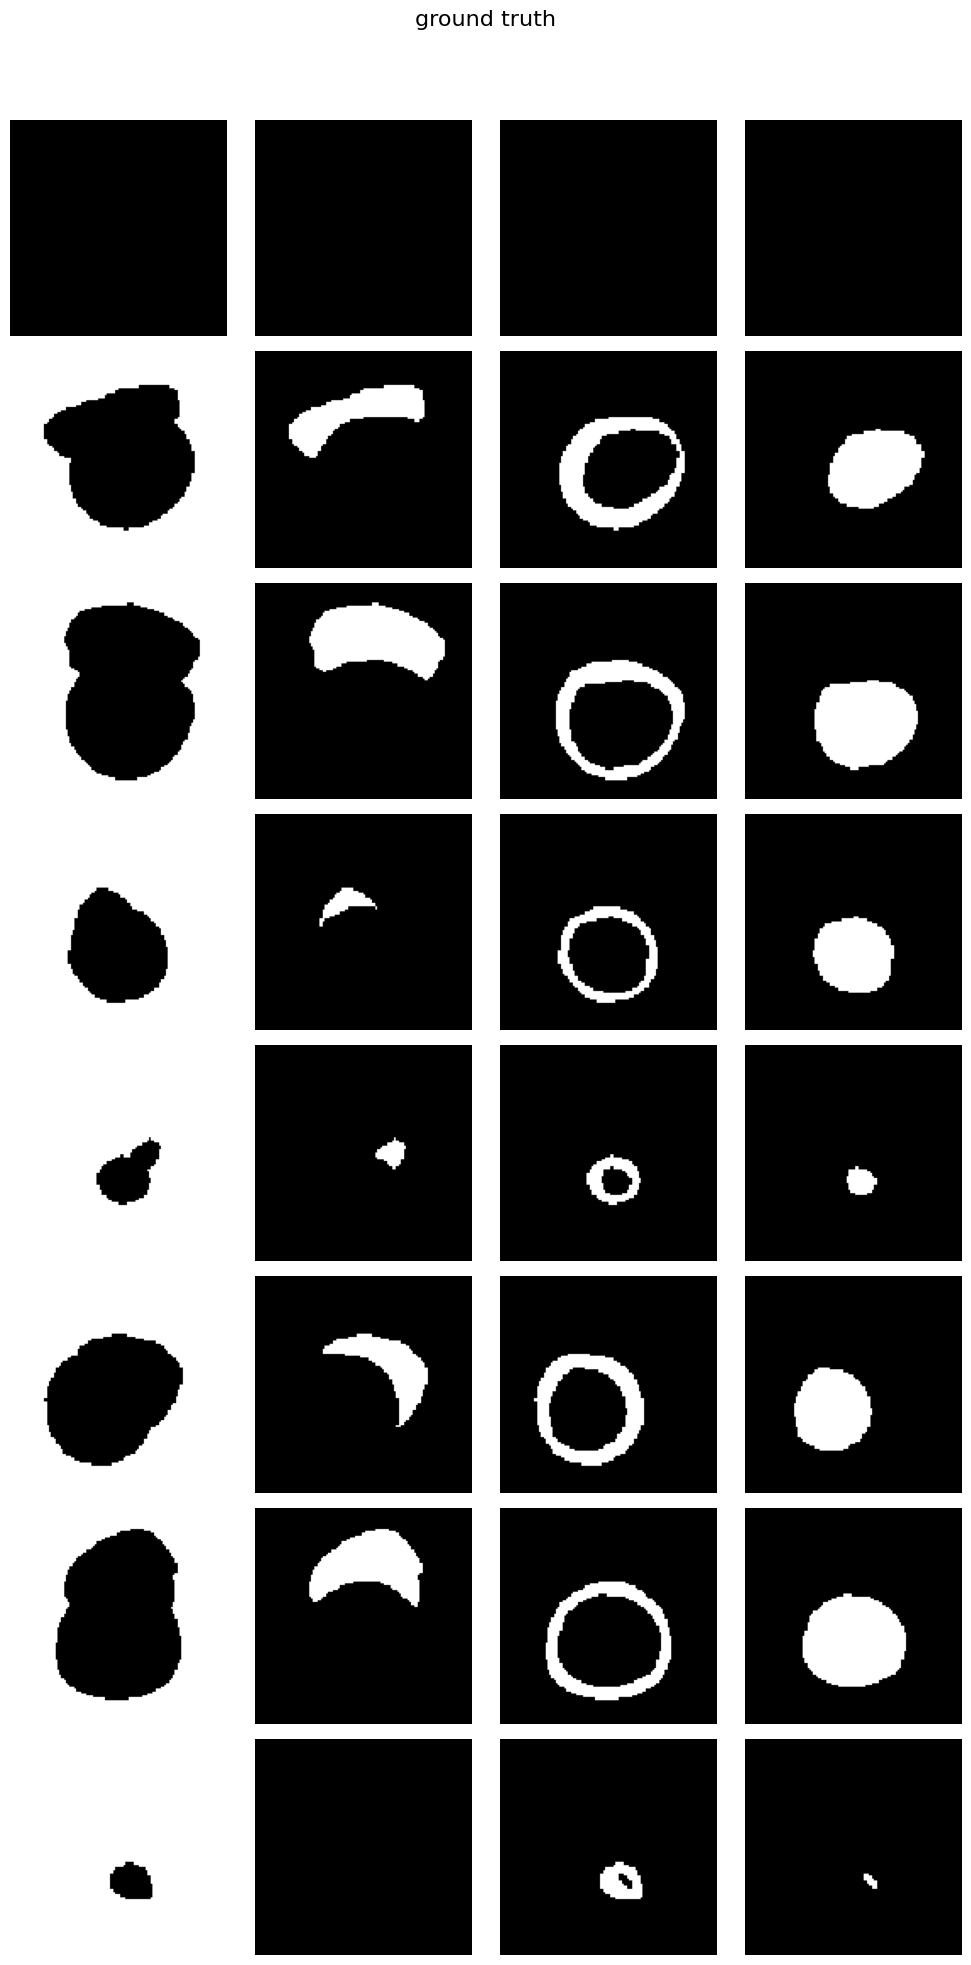

In [18]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

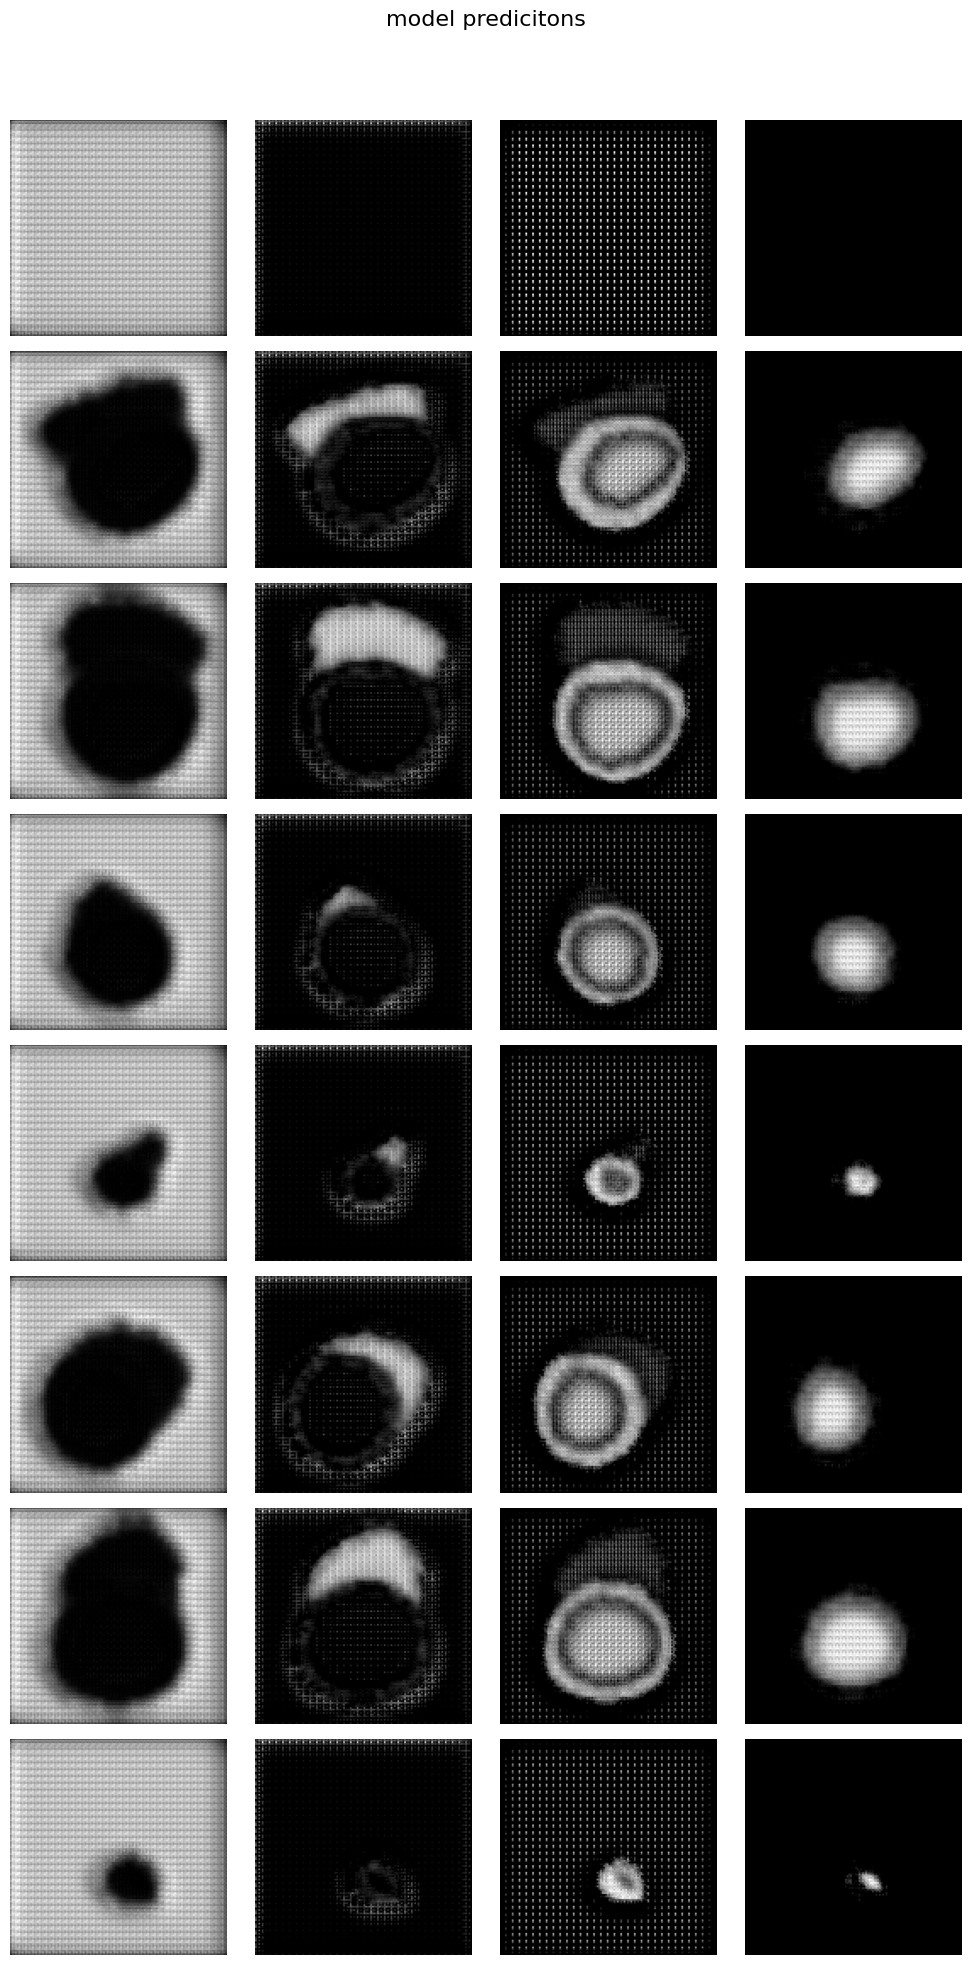

In [19]:
batch_hat = reconstruct(vis_batch, model)

visualize_batch( batch_hat.detach().cpu(), title = "model predicitons")

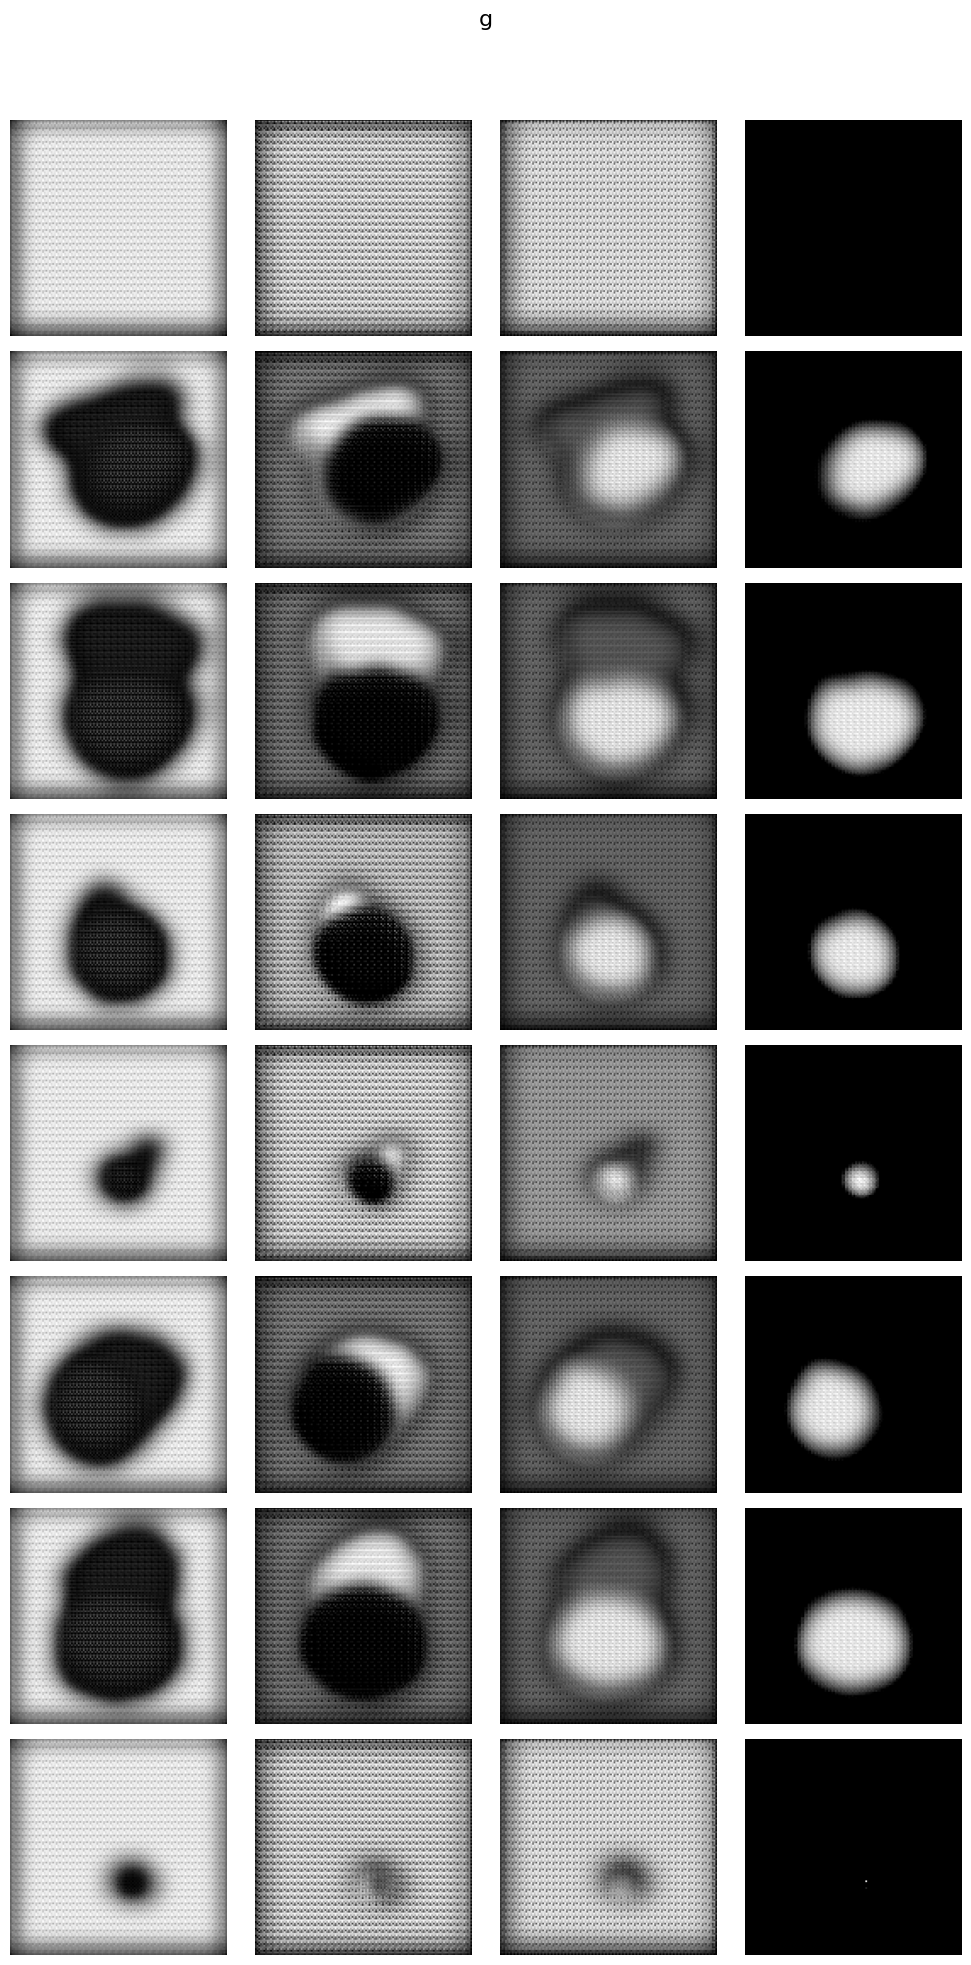

In [1]:
visualize_batch(recons_evolution[1].detach().cpu(), title = "g")